,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
901,s01,p736,216,153,19,8,FALSE
902,s02,p736,605,44,31,3,FALSE
903,s03,p736,672,70,27,5,FALSE


[1] 136   7

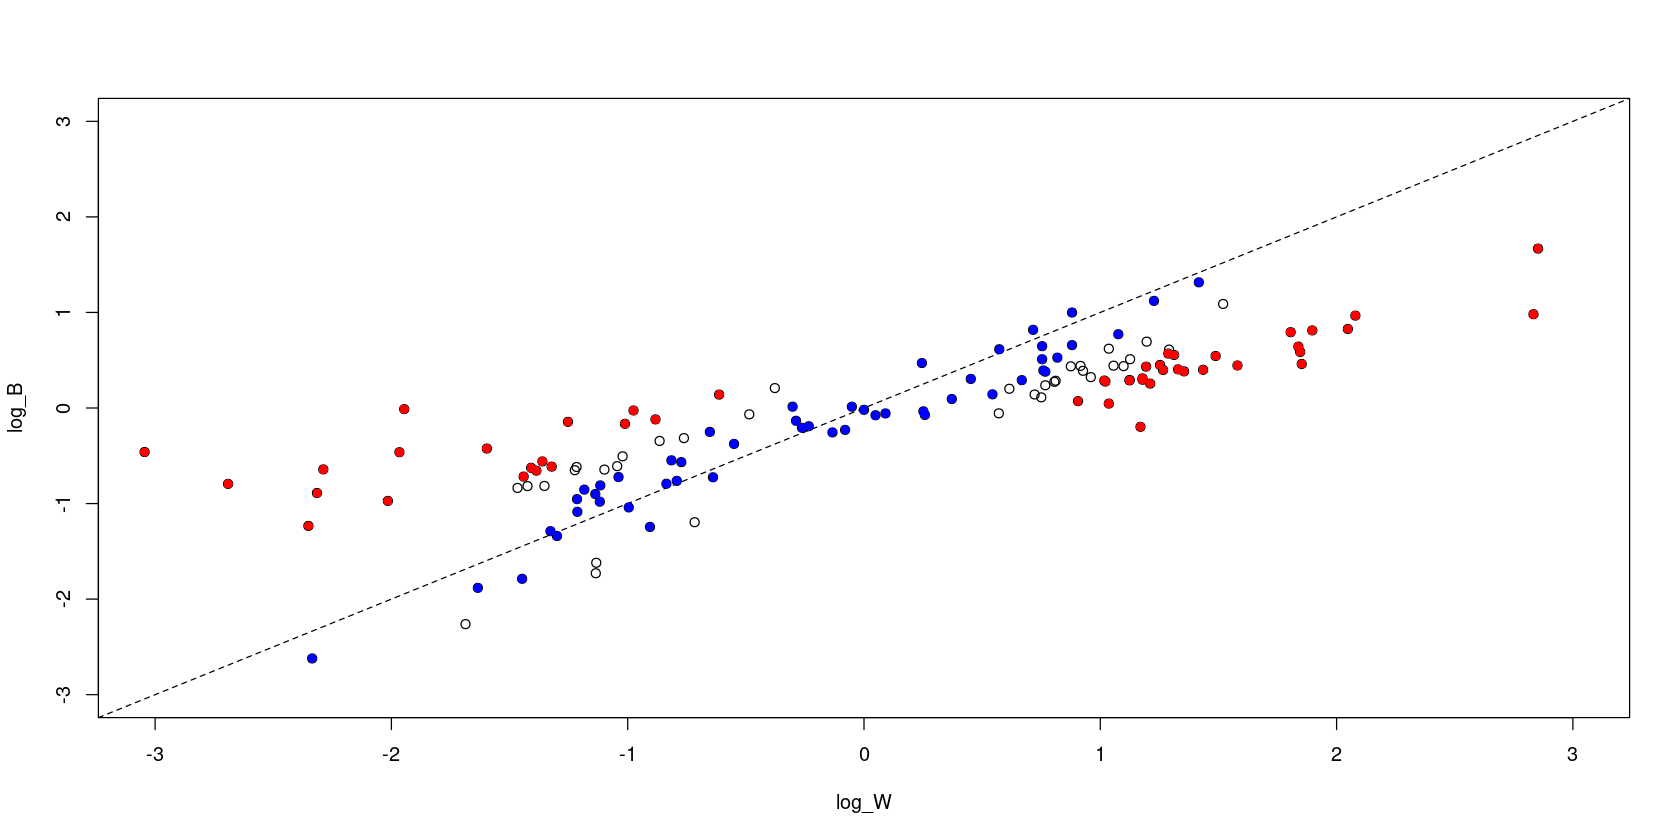

In [101]:
equilibrium <- read.csv('~/ResearchProjects/JAPE/ConcurrentData/matching_by_session.csv')
stable <- subset(equilibrium,!dynamic_env)

bb <- unique(stable$bird)[6]
bb_stable <- subset(stable,bird==bb)
head(bb_stable,3)
dim(bb_stable)

bb_stable <- bb_stable[-c(4,9),] # Leverage/Outliers

log_W <- log(bb_stable$n_reinf_right/bb_stable$n_reinf_left)
log_B <- log(bb_stable$n_resp_right/bb_stable$n_resp_left)


distances <- abs(-log_W+log_B)/sqrt(2)

n_select <- 50
W_r <- array(dim=c(n_select,2))
W_l <- array(dim=c(n_select,2))
B_r <- array(dim=c(n_select,2))
B_l <- array(dim=c(n_select,2))
# Closer to matching:
W_r[,1] <- bb_stable$n_reinf_right[order(distances,decreasing=F)][1:n_select]
W_l[,1] <- bb_stable$n_reinf_left[order(distances,decreasing=F)][1:n_select]
B_r[,1] <- bb_stable$n_resp_right[order(distances,decreasing=F)][1:n_select]
B_l[,1] <- bb_stable$n_resp_left[order(distances,decreasing=F)][1:n_select]
# Farther from matching:
W_r[,2] <- bb_stable$n_reinf_right[order(distances,decreasing=T)][1:n_select]
W_l[,2] <- bb_stable$n_reinf_left[order(distances,decreasing=T)][1:n_select]
B_r[,2] <- bb_stable$n_resp_right[order(distances,decreasing=T)][1:n_select]
B_l[,2] <- bb_stable$n_resp_left[order(distances,decreasing=T)][1:n_select]



plot(log_W,log_B,
     xlim=c(-3,3),ylim=c(-3,3));abline(0,1,lty='dashed')
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=16,col='blue')
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=16,col='red')
# points(log_W[order(distances)][1:50],
#        log_B[order(distances)][1:50],pch=16,col='blue')
# points(log_W[order(distances,decreasing=T)][1:50],
#        log_B[order(distances,decreasing=T)][1:50],pch=16,col='red')
# text(log_W,log_B,pch=paste(1:length(log_W)),cex=1.5)

In [102]:
library('R2jags')

In [103]:
observed <- list('W_r','W_l','B_r','B_l','n_select')
unobserved <- c('mu_lambda_l_post','sigma_lambda_l_post','mu_lambda_r_post','sigma_lambda_r_post',
                'mu_gamma_l_post','sigma_gamma_l_post','mu_gamma_r_post','sigma_gamma_r_post',
                'lambda_l_post','lambda_r_post',
                'gamma_l_post','gamma_r_post',
                'alpha_post','beta_post')

In [105]:
write('

model{
    for(j in 1:2){ # Matching conditions

        alpha_post[j]~dnorm(0,1)
        beta_post[j]~dnorm(0,1)

#         mu_lambda_r_post[j]~dnorm(0,1)
#         mu_lambda_l_post[j]~dnorm(0,1)

        mu_lambda_r_post[j] <- alpha_post[j]/2+beta_post[j]
        mu_lambda_l_post[j] <- -alpha_post[j]/2+beta_post[j]

        mu_gamma_r_post[j]~dnorm(0,1)
        mu_gamma_l_post[j]~dnorm(0,1)
        sigma_lambda_r_post[j]~dunif(0,10)
        sigma_lambda_l_post[j]~dunif(0,10)
        sigma_gamma_r_post[j]~dunif(0,10)
        sigma_gamma_l_post[j]~dunif(0,10)
        tau_lambda_r_post[j] <- 1/sigma_lambda_r_post[j]^2
        tau_lambda_l_post[j] <- 1/sigma_lambda_l_post[j]^2
        tau_gamma_r_post[j] <- 1/sigma_gamma_r_post[j]^2
        tau_gamma_l_post[j] <- 1/sigma_gamma_l_post[j]^2

        for(i in 1:n_select){ # Observations within conditions
#             lambda_r_post[i]~dlnorm(alpha_post/2+beta_post*log(W_r[i]),tau_post)
#             lambda_l_post[i]~dlnorm(-alpha_post/2+beta_post*log(W_l[i]),tau_post)

            lambda_r_post[i,j]~dlnorm(mu_lambda_r_post[j],tau_lambda_r_post[j])
            lambda_l_post[i,j]~dlnorm(mu_lambda_l_post[j],tau_lambda_l_post[j])
            gamma_r_post[i,j]~dlnorm(mu_gamma_r_post[j],tau_gamma_r_post[j])
            gamma_l_post[i,j]~dlnorm(mu_gamma_l_post[j],tau_gamma_l_post[j])
            
            # Observed
            W_r[i,j]~dpois(gamma_r_post[i,j])
            W_l[i,j]~dpois(gamma_l_post[i,j])
            B_r[i,j]~dpois(lambda_r_post[i,j])
            B_l[i,j]~dpois(lambda_l_post[i,j])

        }
    }
}

','jamm.bug') # Just Another Matching Model

bayes <- jags(data = observed,
              parameters.to.save=unobserved,
              model.file='jamm.bug')
unlink('jamm.bug')
summary(bayes$BUGSoutput$summary[,c('Rhat','n.eff')])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 416
   Total graph size: 847

Initializing model



      Rhat           n.eff     
 Min.   :1.000   Min.   : 310  
 1st Qu.:1.001   1st Qu.:1200  
 Median :1.002   Median :2400  
 Mean   :1.002   Mean   :2125  
 3rd Qu.:1.003   3rd Qu.:3000  
 Max.   :1.008   Max.   :3000  

In [106]:
nds_bayes <- bayes$BUGSoutput$sims.list
names(nds_bayes)

[1] "alpha_post"          "beta_post"           "deviance"           
 [4] "gamma_l_post"        "gamma_r_post"        "lambda_l_post"      
 [7] "lambda_r_post"       "mu_gamma_l_post"     "mu_gamma_r_post"    
[10] "mu_lambda_l_post"    "mu_lambda_r_post"    "sigma_gamma_l_post" 
[13] "sigma_gamma_r_post"  "sigma_lambda_l_post" "sigma_lambda_r_post"

In [111]:
bayes

Inference for Bugs model at "jamm.bug", fit using jags,
 3 chains, each with 2000 iterations (first 1000 discarded)
 n.sims = 3000 iterations saved
                        mu.vect sd.vect     2.5%      25%      50%      75%
alpha_post[1]            -0.247   0.109   -0.458   -0.322   -0.248   -0.174
alpha_post[2]             0.075   0.089   -0.102    0.016    0.074    0.135
beta_post[1]              6.263   0.052    6.161    6.228    6.263    6.298
beta_post[2]              6.382   0.045    6.294    6.352    6.382    6.412
gamma_l_post[1,1]        19.485   3.875   12.775   16.806   19.306   21.938
gamma_l_post[2,1]        49.920   6.834   37.626   45.207   49.479   54.351
gamma_l_post[3,1]        46.283   6.457   34.730   41.662   45.909   50.421
gamma_l_post[4,1]        52.048   7.203   38.637   46.900   52.020   56.629
gamma_l_post[5,1]        22.856   4.369   15.045   19.708   22.568   25.775
gamma_l_post[6,1]        24.396   4.638   16.375   21.224   24.030   27.207
gamma_l_post[7,1

In [107]:
dim(nds$gamma_l_post)

[1] 3000   50    2

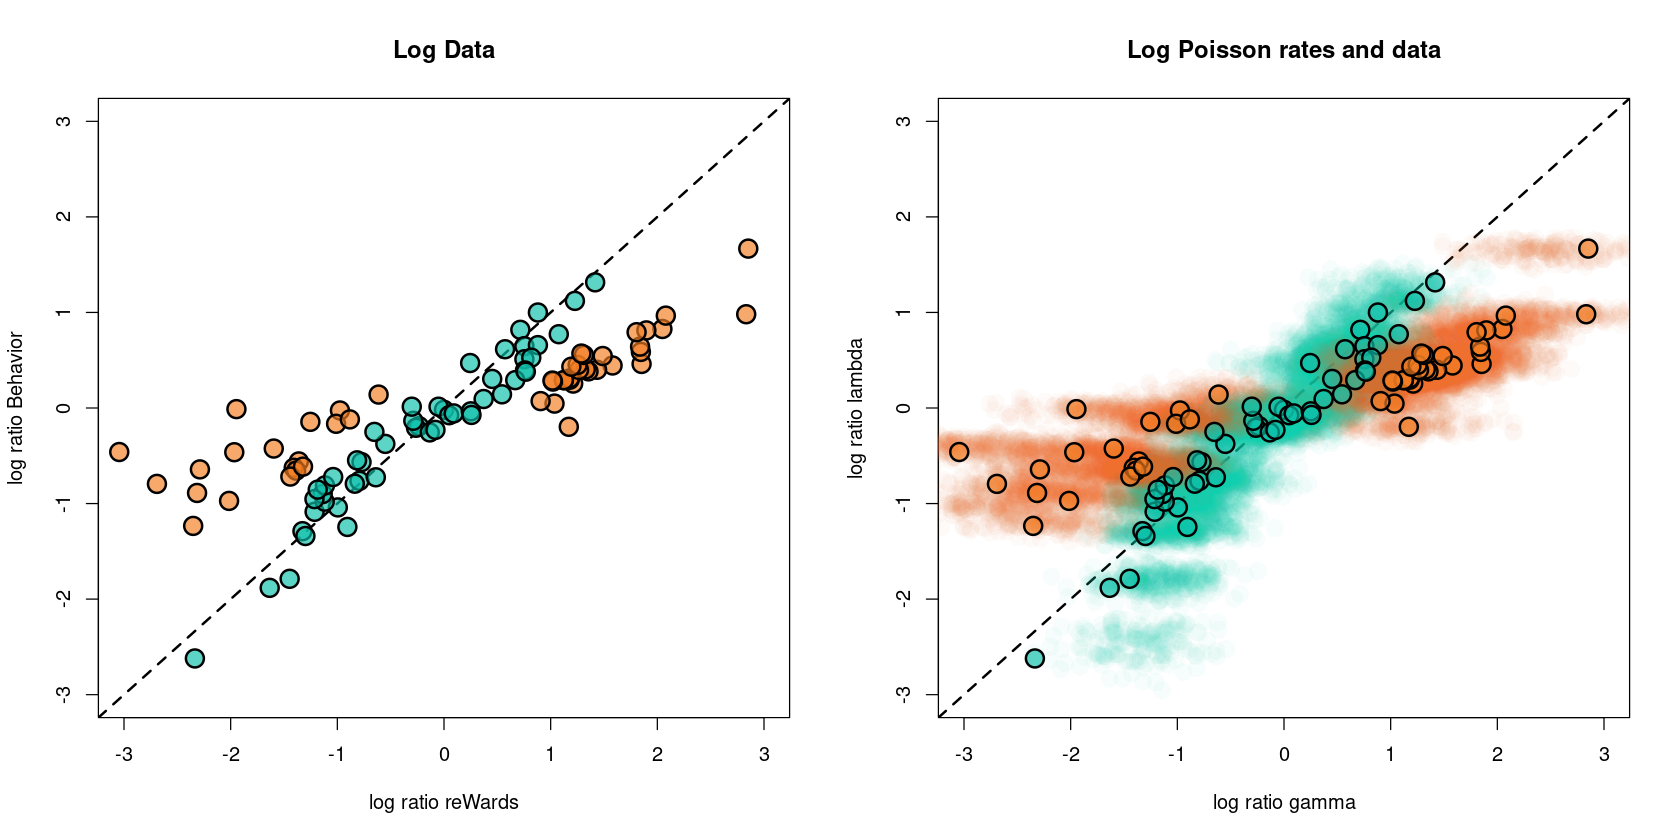

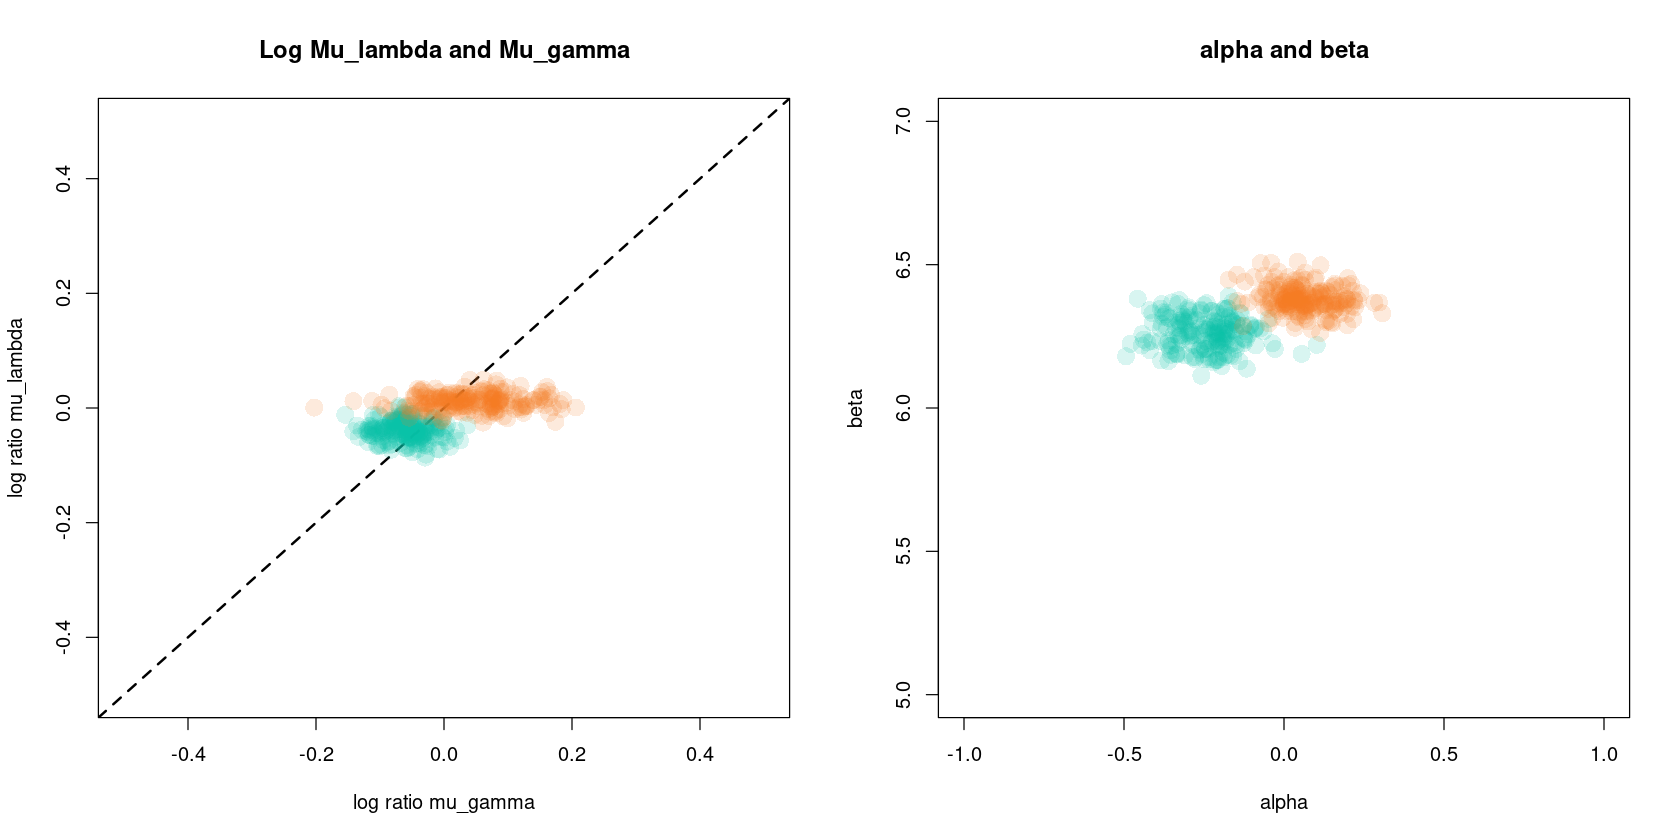

In [120]:
col_matching <- '#0cc0aa'
col_under <- '#f37d21'

nds <- nds_bayes

options(repr.plot.width=14)
layout(matrix(1:2,ncol = 2))

# Data plot
plot(NULL,xlim=c(-3,3),ylim=c(-3,3),
     main='Log Data',xlab='log ratio reWards',ylab='log ratio Behavior')
abline(0,1,lty='dashed',lwd=2)
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)

# Lambda and Gamma plot (nodes next to data)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-3,3),ylim=c(-3,3),
     main='Log Poisson rates and data',xlab='log ratio gamma',ylab='log ratio lambda')
abline(0,1,lty='dashed',lwd=2)
points(log(nds$gamma_r_post[sample_index,,1]/nds$gamma_l_post[sample_index,,1]),
       log(nds$lambda_r_post[sample_index,,1]/nds$lambda_l_post[sample_index,,1]),
       pch=16,col=paste(col_matching,'08',sep=''),cex=2)
points(log(nds$gamma_r_post[sample_index,,2]/nds$gamma_l_post[sample_index,,2]),
       log(nds$lambda_r_post[sample_index,,2]/nds$lambda_l_post[sample_index,,2]),
       pch=16,col=paste(col_under,'08',sep=''),cex=2)
points(log(W_r[,1]/W_l[,1]),
       log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
points(log(W_r[,2]/W_l[,2]),
       log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)

# Mu_lambda and Mu_gamma plot ('matching distance condition' parameters)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-.5,.5),ylim=c(-.5,.5),
     main='Log Mu_lambda and Mu_gamma',xlab='log ratio mu_gamma',ylab='log ratio mu_lambda')
abline(0,1,lty='dashed',lwd=2)
points(log(nds$mu_gamma_r_post[sample_index,1]/nds$mu_gamma_l_post[sample_index,1]),
       log(nds$mu_lambda_r_post[sample_index,1]/nds$mu_lambda_l_post[sample_index,1]),
       pch=16,col=paste(col_matching,'28',sep=''),cex=2)
points(log(nds$mu_gamma_r_post[sample_index,2]/nds$mu_gamma_l_post[sample_index,2]),
       log(nds$mu_lambda_r_post[sample_index,2]/nds$mu_lambda_l_post[sample_index,2]),
       pch=16,col=paste(col_under,'28',sep=''),cex=2)
# points(log(W_r[,1]/W_l[,1]),
#        log(B_r[,1]/B_l[,1]),pch=21,bg=paste(col_matching,'aa',sep=''),cex=2,lwd=2)
# points(log(W_r[,2]/W_l[,2]),
#        log(B_r[,2]/B_l[,2]),pch=21,bg=paste(col_under,'aa',sep=''),cex=2,lwd=2)


# alpha and beta plot ('matching distance condition' parameters)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-1,1),ylim=c(5,7),
     main='alpha and beta',xlab='alpha',ylab='beta')
abline(0,1,lty='dashed',lwd=2)
points(nds$alpha_post[sample_index,1],
       nds$beta_post[sample_index,1],
       pch=16,col=paste(col_matching,'28',sep=''),cex=2)
points(nds$alpha_post[sample_index,2],
       nds$beta_post[sample_index,2],
       pch=16,col=paste(col_under,'28',sep=''),cex=2)

# tau_r and tau_l ('matching distance condition' parameters)
sample_index <- sample(dim(nds$gamma_l_post)[1],size=200)
plot(NULL,xlim=c(-1,1),ylim=c(5,7),
     main='alpha and beta',xlab='alpha',ylab='beta')
abline(0,1,lty='dashed',lwd=2)
points(nds$alpha_post[sample_index,1],
       nds$beta_post[sample_index,1],
       pch=16,col=paste(col_matching,'28',sep=''),cex=2)
points(nds$alpha_post[sample_index,2],
       nds$beta_post[sample_index,2],
       pch=16,col=paste(col_under,'28',sep=''),cex=2)